This is my first attempt at creating and training my own neural network. I'll be training my model on the MNIST dataset to recognize numbers 0-9. This will be a convolutional neural network built from scratch. The problem is simple enough to not really need a pretrained base model.


I may try to expand this project to include a drawing board where users can draw their own numbers and have my model predict them.

# Imports #

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split


SEED = 31415

np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.16.1
1.26.4
2.2.2


# Loading Data #

In [2]:
df_train = pd.read_csv("../input/digit-recognizer/train.csv")
print(df_train.shape)
df_train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv("../input/digit-recognizer/test.csv")
print(df_test.shape)
df_test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each image is represented using 784 features. Each feature represents a pixel in a 28\*28 grid. The pixels are numbered left to right, top to bottom where the top left pixel is pixel0 and the pixel directly below it is pixel28. The `label` feature in the training data is the represented number.

Each pixel can have a value from 0-255 where 0 is black and 255 is white.

# Data Analysis #



In [4]:
print("Missing values:")
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())
print("------------------")
print(df_train.dtypes.value_counts())
print(df_test.dtypes.value_counts())

Missing values:
0
0
------------------
int64    785
Name: count, dtype: int64
int64    784
Name: count, dtype: int64


The dataset has no missing values and all columns are appropriately encoded as type `int64`. This reduces the amount of preprocessing needed.

<Axes: xlabel='label', ylabel='count'>

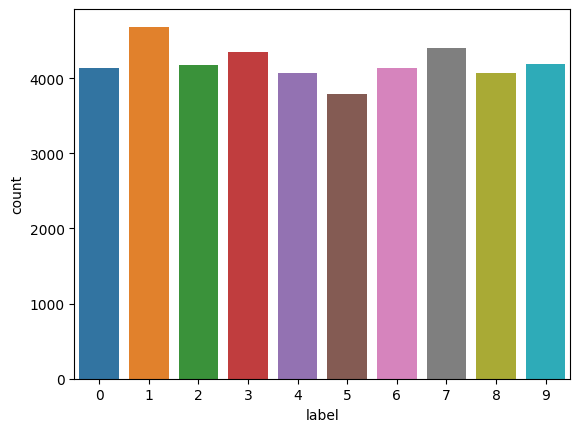

In [5]:
sns.countplot(x="label", data=df_train)

We have a fairly even distribution of numbers within the training set.

# Preprocessing #

We normalize the data and reshape it so that the CNN can handle it. 

In [6]:
X_train = df_train.copy()
y_train = X_train.pop("label")
X_test = df_test.copy()

#Normalize data
X_train = X_train / 255
X_test = X_test / 255

#Reshape data, 28x28, 1 channel
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

Here's a look at the first couple entries of our training data

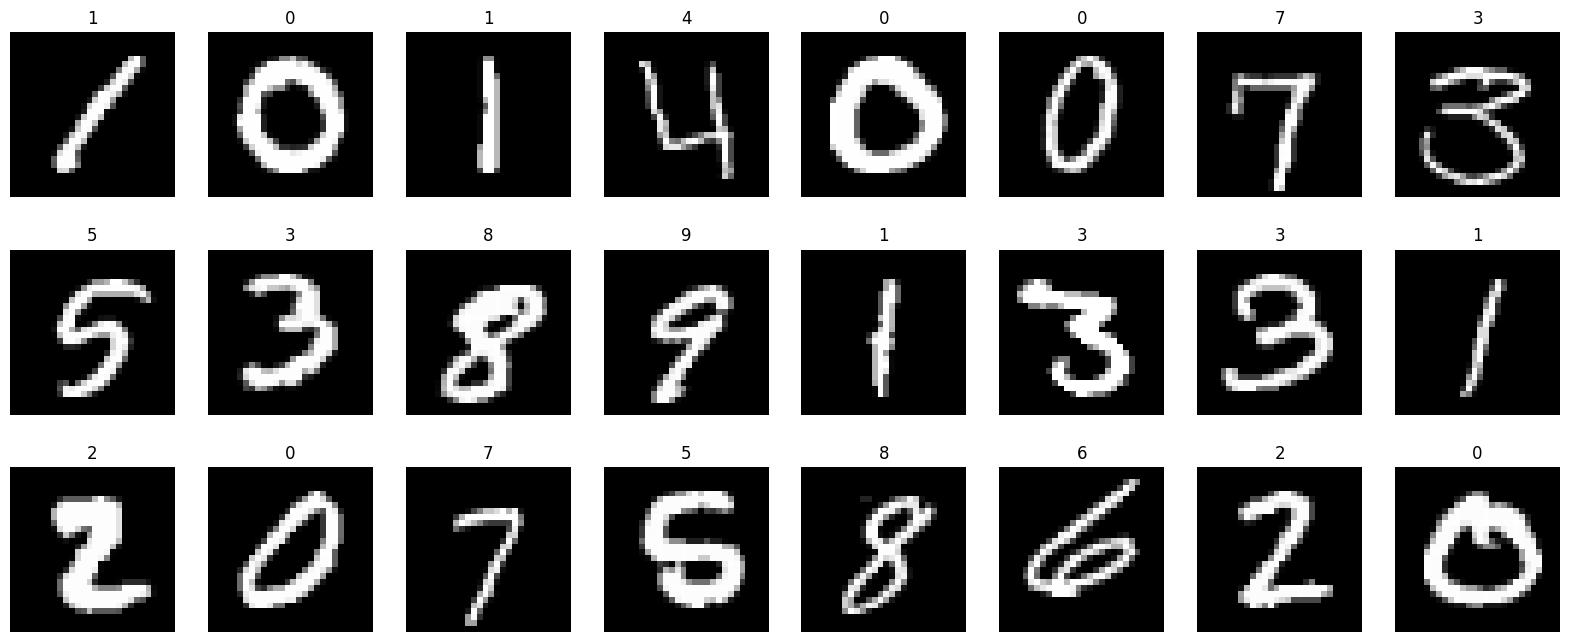

In [7]:
#Display first n X_train entries
n_rows, n_cols = 3, 8
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,8))
axs = axs.flatten()
for i in range(n_rows*n_cols):
    axs[i].imshow(X_train[i], cmap="gray") 
    axs[i].set_title(y_train[i])
    axs[i].axis("off")

One-hot encoding the target also helps the CNN training. 

In [8]:
#e.g. 4 becomes [0,0,0,0,1,0,0,0,0,0]
y_train = to_categorical(y_train, num_classes=10)

Now, we'll extract our validation data from our training data. Given that the dataset is relatively large, we'll use 10% of the training data as validation.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

# Data Augmentation #
To help prevent overfitting, I also created a model to augment data. I chose to incorporate small amounts of rotation, zoom, and translation. I chose to exclude image flipping since that could drastically change the number being represented, especially with 6 and 9. I also tried to change brightness but the images seemed very sensitive to brightness changes and i couldn't get it to produce recognizable images consistently.

The augmentation seemed to work well because the validation loss followed the training loss much better after applying it.

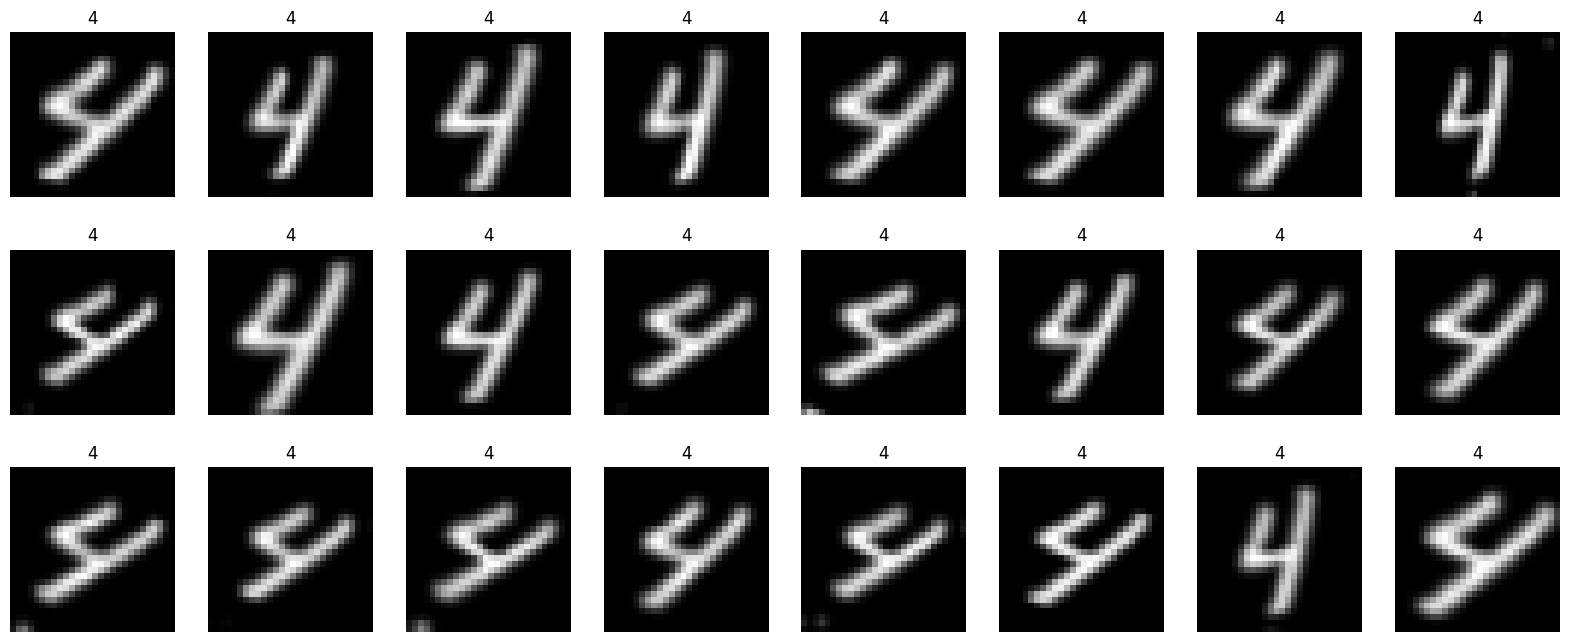

In [20]:
#Data augmentation
image_gen = keras.Sequential([
    layers.RandomRotation(0.075),
    layers.RandomZoom(0.15),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
    layers.Resizing(28, 28),
])

#Show some augmented examples
image_index = 27
n_rows, n_cols = 3, 8

example = X_train[image_index]
label = np.argmax(y_train[image_index])
augmented_examples = [image_gen(example) for _ in range(n_rows*n_cols)]

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axs = axs.flatten()
for i in range(n_rows * n_cols):
    axs[i].imshow(augmented_examples[i], cmap="gray")
    axs[i].set_title(label)
    axs[i].axis("off")

# Model Creation and Training #

The model starts with the same image augmentation used above. I put the augmentation within the model itself to offload work to the GPU. When I initially tried using tensorflow's map() function to augment the data, I experienced a heavy CPU bottleneck.

To create the convolutional base, I opted for 3 blocks with batch normalization, same padding, max pooling, and dropout. Same padding seemed most viable since the images are already low resolution and the border values seem to hold little information. Max pooling and batch normalization help reduce overfitting and allow the model to capture the overall patterns. Droupout was also key to boosting model performance. On average the model performed much better after I added 20% dropout in the blocks.

The last block fo the base only has a convolution and batch normalization layer. THis is because it seemed to hurt adding max pooling and dropout to this last layer. This might be because too much information was being lost. 

Finally, I applied a global average pooling layer before the dense head to fruther combat overfitting.


For the dense head, I opted for one hidden layer with a dropout layer in between. This setup seemed to work well, likely because the MNIST problem is fairly simple. I tried experimenting with two hidden layers but the model consistently got high losses. It seemed to heavily overfit.

In [28]:
model = keras.Sequential([
    layers.InputLayer(shape=(28, 28, 1)),
    
    #Image augmentation
    layers.RandomRotation(0.075),
    layers.RandomZoom(0.15),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
    layers.Resizing(28, 28),
    
    #Block 1
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block 2
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block 3
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    
    #Dense Head
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_4               │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_4 (RandomHeight)  │ (None, None, 28, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_4 (RandomWidth)    │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_4 (Resizing)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

Compile the model using Adam optimization

In [29]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

Define a ReduceLR and EarlyStopping callback to help model performance and stop training if no progress.

In [30]:
epochs = 50
batch_size = 64 

#Reduce lr when no improvement
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,  
    patience=3,  
    min_lr=1e-6  
)

#Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10, 
    restore_best_weights=True 
)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1 )

Epoch 1/50


2024-09-04 08:08:25.936257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7279 - loss: 0.8650 - val_accuracy: 0.8967 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9564 - loss: 0.1441 - val_accuracy: 0.9560 - val_loss: 0.1376 - learning_rate: 0.0010
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9676 - loss: 0.1041 - val_accuracy: 0.9812 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9723 - loss: 0.0868 - val_accuracy: 0.9840 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9762 - loss: 0.0769 - val_accuracy: 0.9679 - val_loss: 0.0973 - learning_rate: 0.0010
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9792 - loss: 0.0677 - val_accuracy: 0.9798 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9793 - loss: 0.0695 - val_

Best validation loss: 0.01705016940832138
Best validation accuracy: 0.9952380657196045


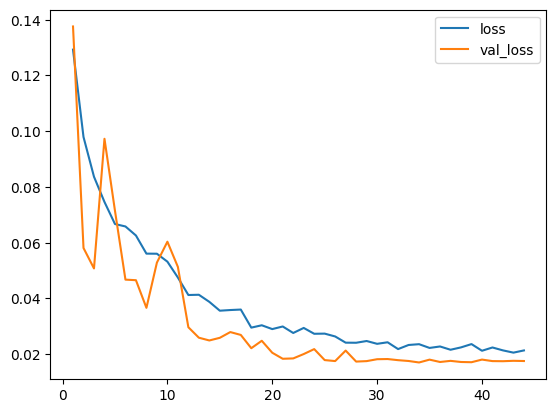

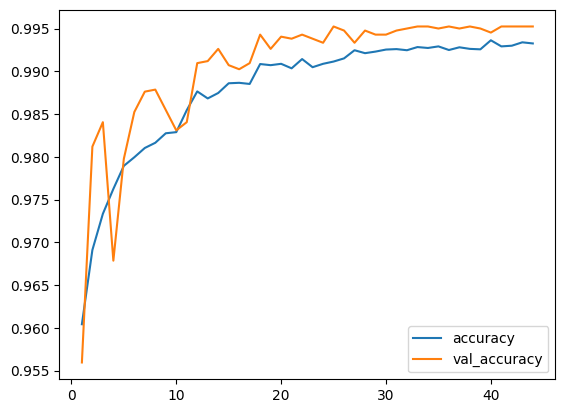

In [31]:
df_history = pd.DataFrame(history.history)
print(f"Best validation loss: {df_history['val_loss'].min()}")
print(f"Best validation accuracy: {df_history['val_accuracy'].max()}")
df_history.loc[1:, ['loss', 'val_loss']].plot()
df_history.loc[1:, ['accuracy', 'val_accuracy']].plot();

Here are some logs of model iterations:

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
    Best validation loss: 0.042459383606910706
    Best validation accuracy: 0.9902380704879761
---
    Added image augmentation
    Best validation loss: 0.02707359939813614
    Best validation accuracy: 0.9923809766769409
---
    Removed Global average pooling
    Best validation loss: 0.04386579617857933
    Best validation accuracy: 0.9902380704879761
---
    Reincorporated global average pooling
    Added reducelr and earlystopping callbacks
    increased number of neurons in dense layer to 128
    Best validation loss: 0.029842104762792587
    Best validation accuracy: 0.9933333396911621
---
    Added .2 Dropout after first two Conv2D blocks
    50 Epochs
    Best validation loss: 0.020908987149596214
    Best validation accuracy: 0.9950000047683716
---
    Removed Global average pooling
    Changed dense head:
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
    Best validation loss: 0.02835962548851967
    Best validation accuracy: 0.9940476417541504

In [38]:
#Save model for download
model.save("/kaggle/working/mnist_model.keras")

In [33]:
# import os

# file_path = '/kaggle/working/mnist_model.keras'


# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f'{file_path} has been removed.')
# else:
#     print(f'The file {file_path} does not exist.')

# Create Submission #

For Kaggle competition submission (uses MNIST testing set)

In [36]:
preds = model.predict(X_test)
preds = np.argmax(preds,axis=1) #Get highest probability

preds = pd.DataFrame({
    'Label': preds
}, index=df_test.index)
preds.index += 1 #ImageIds should start at 1
preds.index.name = 'ImageID'

preds.to_csv("submission.csv")

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [37]:
preds

,Label
ImageID,
1,2
2,0
3,9
4,0
5,3
...,...
27996,9
27997,7
27998,3
